# Question 3: What factors influence the income of an Airbnb apartment in Berlin?
Now that we know how much money one can make with Airbnb apartments in Berlin, I'd like to answer another question. The third question around the Airbnb Berlin data set is about the __factors that influence a listing's income__. Knowing these things in advance allows Airbnb apartment owners to __make the most out of their renting offers__.


Similar to the previous two, the analysis is divided into the following __five steps__:
* 1 - Load libraries
* 2 - Import & understand data
* 3 - Pre-process data
* 4 - Model data
* 5 - Analyze data & evaluate results

## 1 - Load Libraries

In [144]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import folium

%matplotlib inline

## 2 - Import & Understand Data

In [178]:
# Import listings data (Source: http://insideairbnb.com/get-the-data.html)
df_listings = pd.read_csv('../data/listings_berlin.csv')

# Preview data
print(df_listings.shape)
pd.options.display.max_columns = None
df_listings.head(1)

(22572, 96)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20180912025131,2018-09-12,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and U2 (metro), Trams M12, ...","Simple kitchen/cooking, refrigerator, microwav...",Always available,"No parties No events No pets No smoking, not e...",NaN,NaN,https://a0.muscache.com/im/pictures/260fd609-7...,NaN,2217,https://www.airbnb.com/users/show/2217,Ian,2008-08-18,"Key Biscayne, Florida, United States",Believe in sharing economy.,within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/21428a22-4...,https://a0.muscache.com/im/pictures/21428a22-4...,Mitte,3.0,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Mitte,Brunnenstr. Süd,Mitte,Berlin,Berlin,10119,Berlin,"Berlin, Germany",DE,Germany,52.534537,13.402557,f,Guesthouse,Entire home/apt,3,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",NaN,$60.00,NaN,NaN,$200.00,$30.00,1,$28.00,4,1125,6 weeks ago,t,5,34,64,154,2018-09-12,109,2016-04-11,2018-09-08,92.0,9.0,9.0,10.0,10.0,10.0,9.0,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,3,3.69


### 2.1 - Overview

The data set holds many columns which could potentially have an influence on the monthly income of an apartment. Even though one may guess what might be important or not it's important to __confirm or reject__ a subjective assessment with __objective results__. In contrast to the previous two analyses - in which I limited the number of columns to use to a small subset - I'm going to look at a __much larger subset of variables__ now.

## 3 - Pre-Process Data

I want to be able to __combine previous and future results__. Therefore I will apply __similar pre-processing steps__ as used when answering "__Question 1__" and "__Question 2__". Nonetheless, additional pre-processing steps are included in the following section as well.

### 3.1 - Property Types

Removing listings with property types other than "Apartment".

In [179]:
# Check distriutions of property types
property_count = df_listings["property_type"].value_counts().sum()

# Keep only apartments in analysis (~ 90% of listings)
n_all = df_listings.shape[0]
df_listings = df_listings[df_listings["property_type"] == "Apartment"]
print("{} records were removed from the Airbnb Berlin listings data frame.".format(n_all - df_listings.shape[0]))

2255 records were removed from the Airbnb Berlin listings data frame.


### 3.2 - Missing Values

Once again I will check the data set for missing values.

In [180]:
# Define columns to use in analysis
custom_cols = ['accommodates','bathrooms','bedrooms','beds','cleaning_fee','extra_people','guests_included',
               'host_is_superhost','host_response_rate','instant_bookable','monthly_price','minimum_nights',
               'neighbourhood_group_cleansed','number_of_reviews','price','review_scores_rating','reviews_per_month',
               'weekly_price']

In [181]:
# Check for missing values
df_listings[custom_cols].isnull().sum()

accommodates                        0
bathrooms                          34
bedrooms                           13
beds                               27
cleaning_fee                     6624
extra_people                        0
guests_included                     0
host_is_superhost                  19
host_response_rate               8432
instant_bookable                    0
monthly_price                   17868
minimum_nights                      0
neighbourhood_group_cleansed        0
number_of_reviews                   0
price                               0
review_scores_rating             4033
reviews_per_month                3584
weekly_price                    16898
dtype: int64

Now that I'd like to work with more columns it's important to think about the __meaning of missing values__ in each column. I will __keep the missing values for all price columns__ as the corresponding listings simply don't offer different rates. Both "__cleaning_fee__" and "__reviews_per_month__" are going to be __imputed with 0s__, as cleaning fees on the one hand are optinal extra charges and reviews on the other hand are not available thus can bet set to zero. The __superhost flag__ will also be set to __zero__. Last but not least I will run a __mean imputation on "host_response_rate" and "review_scores_rating"__ assuming that listings with missing values perform at least as good as average.

Some of the columns require __additional re-engineering__ steps before their missing values can be imputed. These steps will be included where necessary.

In [182]:
# Imputing missing values for "reviews_per_month"
df_listings["reviews_per_month"] = df_listings["reviews_per_month"].fillna(0)

In [183]:
# Imputing missing values for "host_is_superhost"
df_listings["host_is_superhost"] = df_listings["host_is_superhost"].astype(str).apply(lambda x: 1 if x == "t" else 0)

In [184]:
# Imputing missing values for "review_scores_rating"
df_listings["review_scores_rating"] = df_listings["review_scores_rating"].fillna(df_listings["review_scores_rating"].mean())

In [185]:
# Imputing missing values for "cleaning_fee"
df_listings["cleaning_fee"] = df_listings["cleaning_fee"].fillna("$0.00")

In [186]:
# Imputing missing values for "host_response_rate"
df_listings["host_response_rate"] = df_listings["host_response_rate"].astype(str)
df_listings["host_response_rate"] = df_listings["host_response_rate"].apply(lambda x: x.replace('%','').replace(',',''))
df_listings["host_response_rate"] = df_listings["host_response_rate"].astype(float)
df_listings["host_response_rate"] = df_listings["host_response_rate"].fillna(df_listings["host_response_rate"].mean())

Let's check if everything looks as expected.

In [187]:
# Check again for missing values
df_listings[custom_cols].isnull().sum()

accommodates                        0
bathrooms                          34
bedrooms                           13
beds                               27
cleaning_fee                        0
extra_people                        0
guests_included                     0
host_is_superhost                   0
host_response_rate                  0
instant_bookable                    0
monthly_price                   17868
minimum_nights                      0
neighbourhood_group_cleansed        0
number_of_reviews                   0
price                               0
review_scores_rating                0
reviews_per_month                   0
weekly_price                    16898
dtype: int64

### 3.3 - Neighbourhoods

Only small adjusted to the values of the "neighbourhood_groups" column thus completely optional (as in the previous notebook).

In [188]:
# Adjust values of "neighbourhood_group_cleansed"
df_listings["neighbourhood_group_cleansed"] = df_listings["neighbourhood_group_cleansed"].astype(str).str.replace("Charlottenburg-Wilm.", "Charlottenburg-Wilmersdorf")
df_listings["neighbourhood_group_cleansed"] = df_listings["neighbourhood_group_cleansed"].astype(str).str.replace(" ", "")

Also, I'd like to know __how many listings__ there are in each neighbourhood and if that may have an influence on the actual income. Let's add two more colums to the data set.

In [189]:
# Add listing counts per neighbourhood (group)
df_listings["listings_in_hood"] = df_listings["id"].groupby(df_listings["neighbourhood_cleansed"]).transform("size")
df_listings["listings_in_hood_group"] = df_listings["id"].groupby(df_listings["neighbourhood_group_cleansed"]).transform("size")

### 3.4 - Bookings Per Month

An income estimation requires as to know the number of bookings a listing receives. The calculation happens according to the way I did it when answering "__Question 1__" and "__Question 2__". Please refere to the previous notebook(s) for more details.

In [190]:
# Define adjusted proxy for number of bookings per months
df_listings["max_bookings_per_month"] = (30.42 / df_listings["minimum_nights"]).fillna(0)
df_listings["bookings_per_month"] = df_listings[["max_bookings_per_month","reviews_per_month"]].min(axis=1)
df_listings = df_listings.drop("max_bookings_per_month", axis=1)

I'm also going to add a column showing the __number of bookings per neighbourhood and neighbourhood group__ as a form of competition assessment. We can even add something like the __number bookings per listing__ by using the previously defined columns for listing counts.

In [191]:
# Add booking counts per neighbourhood (group)
df_listings["bookings_in_hood"] = df_listings["bookings_per_month"].groupby(df_listings["neighbourhood_cleansed"]).transform("sum")
df_listings["bookings_in_hood_group"] = df_listings["bookings_per_month"].groupby(df_listings["neighbourhood_group_cleansed"]).transform("sum")

In [192]:
# Add booking counts per neighbourhood (group)
df_listings["bookings_per_listing_in_hood"] = df_listings["bookings_in_hood"] / df_listings["listings_in_hood"]
df_listings["bookings_per_listing_in_hood_group"] = df_listings["bookings_in_hood_group"] / df_listings["listings_in_hood_group"]

### 3.5 Accomodates

In [193]:
# Check if accomodates can be less than guests included
(df_listings["accommodates"] < df_listings["guests_included"]).sum()

95

Apparently, __95 listings offer space for more people than the apartment can actually accomodate__. I'm going to adjust these cases so that the number of guests included doesn't exceed the number of people an apartment can accomodate.

In [194]:
# Adjust values
df_listings["guests_included"] = np.where(df_listings["accommodates"] < df_listings["guests_included"],
                                       df_listings["accommodates"], df_listings["guests_included"])

# Check if adjustment was successful
(df_listings["accommodates"] < df_listings["guests_included"]).sum()

0

### 3.6 - Price

Apparently, all __columns related to price information__ are formatted as objects with a "$" sign in them, I need to convert them to strings in order to remove it. Finally, I can easily convert them to __float values__.

In [195]:
# Convert price columns used in calculation to float
price_cols = ["price","weekly_price","monthly_price","cleaning_fee","extra_people"]

for col in price_cols:
    df_listings[col] = df_listings[col].astype(str)
    df_listings[col] = df_listings[col].apply(lambda x: x.replace('$','').replace(',',''))
    df_listings[col] = df_listings[col].astype(float)

I'm also going to introducde an __adjusted version of "price"__ which includes additinal costs. It's going to represent the __price per person__.

In [196]:
# Create "price_per_person" column (based on total number of possible guests)
df_listings["price_per_person"] = ((
    df_listings["price"] + df_listings["cleaning_fee"] +
    df_listings["extra_people"] * (df_listings["accommodates"] - df_listings["guests_included"]))
    /
    df_listings["guests_included"])

In [197]:
# Summary statistics
df_listings["price_per_person"].describe()

count    20317.000000
mean        68.831503
std        108.743087
min          7.000000
25%         37.500000
50%         55.000000
75%         81.000000
max      11000.000000
Name: price_per_person, dtype: float64

As seen in the previous notebook, the summary statistics already indicate that prices of Airbnb listings may have a couple of __outliers__. Again, I'm going to deal with this later.

### 3.7 - Instant Bookings

This column simply needs a dtype conversion from object to integer so it can be used in later modeling steps.

In [198]:
# Re-engineering of "instant_bookable"
df_listings["instant_bookable"] = df_listings["instant_bookable"].astype(str).apply(lambda x: 1 if x == "t" else 0)

## 4 - Model Data

Finally, I'm going to __model the actual income__ of an Airbnb listing. This step is simply a copy of the one used when working on "__Question 2__" (please go back there for further details).

In [199]:
# Calculate each listing's income per booking
booking_income = []

for (p,wp,mp,n) in zip(df_listings["price"], df_listings["weekly_price"], df_listings["monthly_price"], df_listings["minimum_nights"]):
    price = 0.0
    if n > 29:
        if not math.isnan(mp):
            months = n / 30.0
            price += mp * math.floor(months)
            if not math.isnan(wp):
                weeks = ((months - math.floor(months)) * 30.0) / 7.0
                days = (weeks - math.floor(weeks)) * 7.0
                price += (wp * math.floor(weeks)) + (n * days)
            else:
                days = (months - math.floor(months)) * 30.0
                price += p * days
        elif not math.isnan(wp):
            weeks = n / 7.0
            days = (weeks - math.floor(weeks)) * 7.0
            price += (wp * math.floor(weeks)) + (p * days)
        else:
            price += p * n
    elif n > 6:
        if not math.isnan(wp):
            weeks = n / 7.0
            days = (weeks - math.floor(weeks)) * 7.0
            price += (wp * math.floor(weeks)) + (p * days)
        else:
            price += p * n
    else:
        price += p * n
    
    booking_income.append(price)

# Add to data frame and check summary statistics
df_listings["income_per_booking"] = booking_income
df_listings["income_per_booking"].describe()

count     20317.000000
mean        424.786287
std        6709.878161
min           0.000000
25%          60.000000
50%         120.000000
75%         248.000000
max      900000.000000
Name: income_per_booking, dtype: float64

Let's __transform__ the income per booking column by multiplying it with the __number of bookings per month__. We then get the new column "__income_per_month__".

In [200]:
# Convert the price per booking to a price per months
df_listings["income_per_month"] = df_listings["income_per_booking"] * df_listings["bookings_per_month"]
df_listings["income_per_month"].describe()

count    20317.000000
mean       162.558356
std        414.960914
min          0.000000
25%          6.000000
50%         44.000000
75%        160.000000
max      27000.000000
Name: income_per_month, dtype: float64

## 5 - Analyze Data & Evaluate Results

Before starting off with the analysis I will again remove outliers in "income_per_month" from the data set.

In [201]:
# Remove upper 5% from data set
n_all = df_listings.shape[0]
df_listings = df_listings[df_listings["income_per_month"] <= df_listings["income_per_month"].quantile(.95)]
print("{} records were removed from the Airbnb Berlin listings data frame.".format(n_all - df_listings.shape[0]))

1016 records were removed from the Airbnb Berlin listings data frame.


I've decided to focus my analysis on __correlations between a listings income per month and other columns__ in the data set. It's important to note that the results will __not necessarily reveal causations__. Nonetheless, correlations can be a good __starting point__ in order to understand what things to look for to make the most out one's listing on Airbnb.

In [245]:
# Define columns to use in analysis
custom_cols = ['income_per_month','accommodates','bathrooms','bedrooms','beds','bookings_per_month','bookings_in_hood',
               'bookings_in_hood_group','bookings_per_listing_in_hood','bookings_per_listing_in_hood_group',
               'cleaning_fee','extra_people','guests_included','host_is_superhost','host_response_rate','instant_bookable',
               'listings_in_hood','listings_in_hood_group','minimum_nights','number_of_reviews','price','price_per_person',
               'review_scores_rating','reviews_per_month']

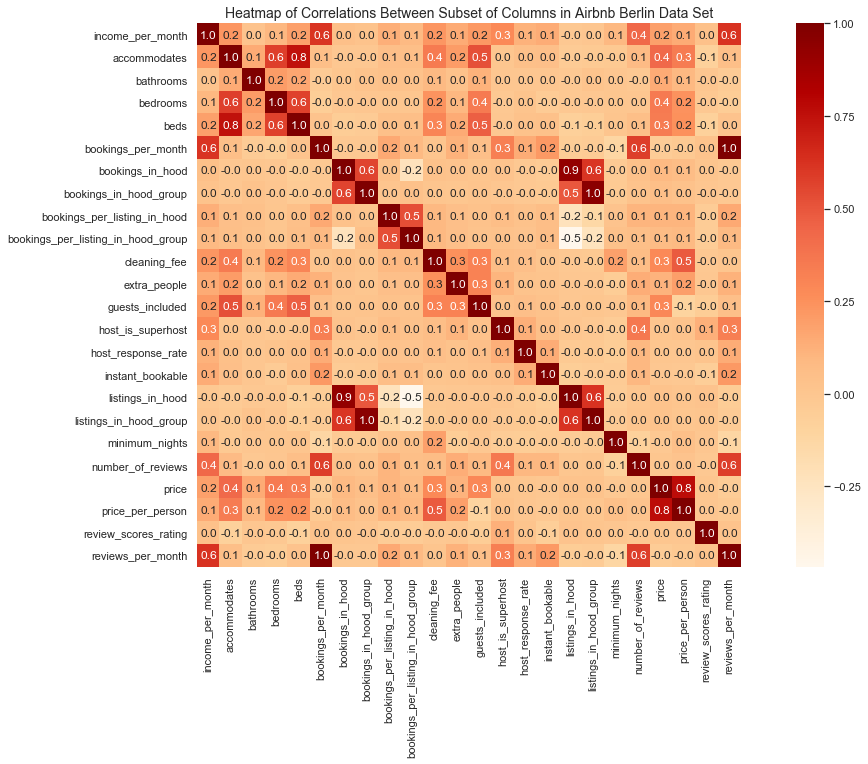

In [246]:
# Get correlations between columns
corrs = df_listings[custom_cols].dropna(axis=0).corr()#.sort_values("income_per_month", ascending=False)

# Plot correlations
plt.subplots(figsize=(20,10))
sns.set(font_scale=1)
corr_plot = sns.heatmap(corrs, yticklabels=custom_cols, xticklabels=custom_cols,
                        cmap="OrRd", cbar=True, annot=True, square=True, fmt=".1f")
corr_plot.set_title("Heatmap of Correlations Between Subset of Columns in Airbnb Berlin Data Set", fontsize=14);

The heatmap above shows the correlation between the pre-defined subset of columns from the listings data set. The __primary focus__ of the analysis is on the heatmap's __first column__ which shows all correlations with a listing's income per month. Let's evaluate the __observations__:

* Correlations are __mainly positive__, despite a small negative correlation with the number of listings in the neighbourhood
* The __strongest__ positive correlations (0.6) can be observed between the __number of bookings/reviews per month__. Both columns are strongly related to each other as the number of bookings per month was based on the number of reviews per month. However, this observation __doesn't really help__ us to gain more information due to the relationship between number of bookings and income __by definition__.
* A __moderate__ positive correlation with __number of reviews__ can as well be explained by its connections to the number of reviews per month.
* A __weak__ positive correlation with the __superhost__ flag indicates that being a good host in general leads to a higher income for a listing (according to Aribnb a host has to meet certain criteria which indicate a higher quality to become a superhost)
* A __weak__ positive correlations with the __number of people__ allowed in the apartment as well as the __number of beds__ finally indicates that __larger apartments earn more money__.

To summarize, the correlations __don't reveal any suprising findings__. Nonetheless, people who are interested in renting out apartments in Berlin could potentially __benefit from offering larger apartments__ as well as following Airbnb guidelines to __become a superhost__ (please see: https://www.airbnb.de/superhost).